Implementation of Example 8.1 Dyna Maze in TextBook [Sutton] (pag. 164)

Algorithm is called Tabular Dyna-Qand it is a mix between planning & acting. 

Although it is called Dyna-Q, also it is a Q-planning algorithm with n-steps. 

If n = 0, it is a Q-learning algorithm.

Algorithm is shown below. If (f) = 0 then it is a Q-learning algorithm

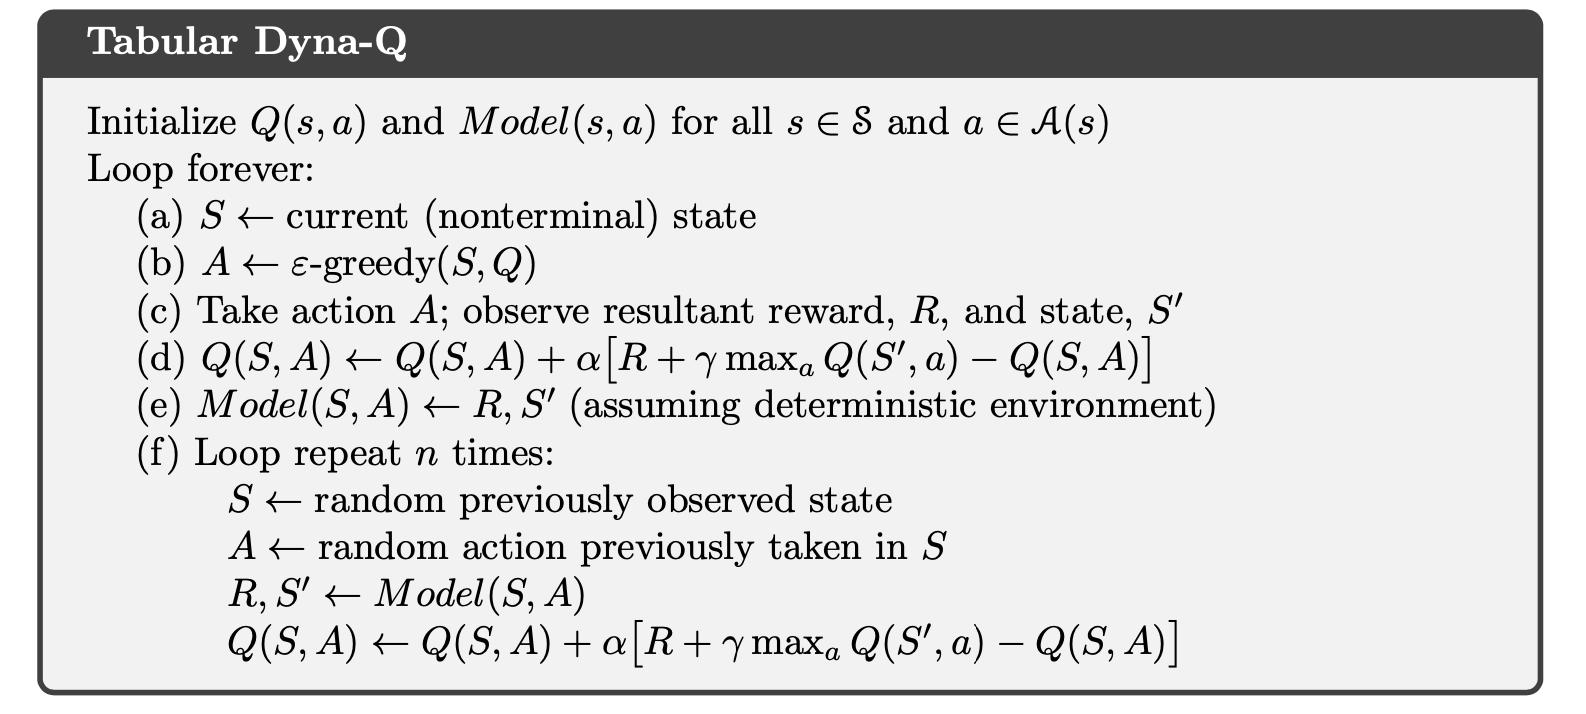

In [14]:
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from matplotlib.table import Table
import pandas as pd


In [15]:
# la clase Maze que contiene la configuracion del laberinto. Es facilmente modificable para cambiar el espacio, los obstaculos y estados inciales y finales

# A wrapper class for a maze, containing all the information about the maze.
# Basically it's initialized to DynaMaze by default, however it can be easily adapted
# to other maze
class Maze:
    def __init__(self):
        # maze width
        self.WORLD_WIDTH = 9

        # maze height
        self.WORLD_HEIGHT = 6

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        self.ACTIONS_FIGS=['↑', '↓', '←', '→']


        # start state
        self.START_STATE = [2, 0]

        # goal state
        self.GOAL_STATES = [[0, 8]]

        # all obstacles
        self.obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
        self.old_obstacles = None
        self.new_obstacles = None

        # time to change obstacles
        self.obstacle_switch_time = None

        # initial state action pair values
        # self.stateActionValues = np.zeros((self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions)))

        # the size of q value
        self.q_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions))

        # max steps
        self.max_steps = float('inf')

        # track the resolution for this maze
        self.resolution = 1

    # extend a state to a higher resolution maze
    # @state: state in lower resoultion maze
    # @factor: extension factor, one state will become factor^2 states after extension
    #def extend_state(self, state, factor):
    #    new_state = [state[0] * factor, state[1] * factor]
    #    new_states = []
    #    for i in range(0, factor):
    #        for j in range(0, factor):
    #            new_states.append([new_state[0] + i, new_state[1] + j])
    #    return new_states

    # extend a state into higher resolution
    # one state in original maze will become @factor^2 states in @return new maze
    #def extend_maze(self, factor):
    #    new_maze = Maze()
    #    new_maze.WORLD_WIDTH = self.WORLD_WIDTH * factor
    #    new_maze.WORLD_HEIGHT = self.WORLD_HEIGHT * factor
    #    new_maze.START_STATE = [self.START_STATE[0] * factor, self.START_STATE[1] * factor]
    #    new_maze.GOAL_STATES = self.extend_state(self.GOAL_STATES[0], factor)
    #    new_maze.obstacles = []
    #    for state in self.obstacles:
    #        new_maze.obstacles.extend(self.extend_state(state, factor))
    #    new_maze.q_size = (new_maze.WORLD_HEIGHT, new_maze.WORLD_WIDTH, len(new_maze.actions))
        # new_maze.stateActionValues = np.zeros((new_maze.WORLD_HEIGHT, new_maze.WORLD_WIDTH, len(new_maze.actions)))
    #    new_maze.resolution = factor
    #    return new_maze

    # take @action in @state
    # @return: [new state, reward]
    def step(self, state, action):
        x, y = state
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        if [x, y] in self.obstacles:
            x, y = state
        if [x, y] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0
        return [x, y], reward

In [16]:
# Parametros del algoritmo
# a wrapper class for parameters of dyna algorithms
class DynaParams:
    def __init__(self):
        # discount
        self.gamma = 0.95

        # probability for exploration
        self.epsilon = 0.1

        # step size
        self.alpha = 0.1

        # weight for elapsed time
        self.time_weight = 0

        # n-step planning
        self.planning_steps = 5

        # average over several independent runs
        self.runs = 10

        # algorithm names
        self.methods = ['Dyna-Q', 'Dyna-Q+']

        # threshold for priority queue
        self.theta = 0

In [17]:
# Clase Modelo que nos servirá para ir guardando la informacion de estados y acciones. Asi es como trabaja este algoritmo, planning y Direct RL
# Trivial model for planning in Dyna-Q
class Model:
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward]

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward

In [18]:
# choose an action based on epsilon-greedy algorithm
def choose_action(state, q_value, maze, dyna_params):
    if np.random.binomial(1, dyna_params.epsilon) == 1:
        #print("------ entre en el 1 ---------")
        return np.random.choice(maze.actions)
    else:
        #print("------ entre en el 2 ---------")
        values = q_value[state[0], state[1], :]
        #print("values:", values)
        #a = np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])
        #print("action es :", a)
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])


In [19]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def steps_dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])
        #print("---------- FIRST q_value -> :", q_value)

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            #print('t ---->', t)

            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])
            #print(" q_value en", t, "--> q_value[state[0], state[1], action]:", q_value[state_[0], state_[1], action_])
        #print("q_value:", q_value)
        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break

    #print("q_value.shape:", q_value.shape)
    #print("len(q_value):", len(q_value))
    #print("q_value.ndim:", q_value.ndim)
    #print("q_value.size:", q_value.size)
    #print("q_value.dtype:", q_value.dtype)
    #print("q_value.dype.name:", q_value.dtype.name)
    #print("q_value:", q_value)
    #q_value_values = np.zeros((maze.WORLD_HEIGHT, maze.WORLD_WIDTH))
    #q_value_policy = np.zeros((maze.WORLD_HEIGHT, maze.WORLD_WIDTH))

    #q_value_values = q_value.max(axis=2)
    #print("q_value_values:",q_value_values)
    #print(maze.ACTIONS_FIGS[q_value.max(axis=2)])

    #q_value_policy = pd.DataFrame(q_value)
    #q_value2 = q_value.copy()
    #q_value2[q_value2 == 0] = -345
    #print("q_value2:", q_value2)
    #q_value_policy = np.argmax(q_value2, axis=2)
    #q_value_policy = np.argmax(q_value, axis=2)
    #print("q_value_policy:",q_value_policy)
    #q_value_policy[q_value2 == 345] = -1
    #print("q_value_policy:",q_value_policy)

    #print("q_value_values.shape:", q_value_values.shape)
    #print("q_value_policy.shape:", q_value_policy.shape)
    #print(q_value_policy)
    #for z in range(0, WORLD_HEIGHT):

    return steps
    #return steps, [q_value]

In [20]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def value_dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])
        #print("---------- FIRST q_value -> :", q_value)

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            #print('t ---->', t)

            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])
            #print(" q_value en", t, "--> q_value[state[0], state[1], action]:", q_value[state_[0], state_[1], action_])
        #print("q_value:", q_value)
        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break

    #print("q_value.shape:", q_value.shape)
    #print("len(q_value):", len(q_value))
    #print("q_value.ndim:", q_value.ndim)
    #print("q_value.size:", q_value.size)
    #print("q_value.dtype:", q_value.dtype)
    #print("q_value.dype.name:", q_value.dtype.name)
    #print("q_value:", q_value)
    q_value_values = np.zeros((maze.WORLD_HEIGHT, maze.WORLD_WIDTH))
    #q_value_policy = np.zeros((maze.WORLD_HEIGHT, maze.WORLD_WIDTH))

    q_value_values = q_value.max(axis=2)
    #print("q_value_values:",q_value_values)
    #print(maze.ACTIONS_FIGS[q_value.max(axis=2)])

    #q_value_policy = pd.DataFrame(q_value)
    #q_value2 = q_value.copy()
    #q_value2[q_value2 == 0] = -345
    #print("q_value2:", q_value2)
    #q_value_policy = np.argmax(q_value2, axis=2)
    #q_value_policy = np.argmax(q_value, axis=2)
    #print("q_value_policy:",q_value_policy)
    #q_value_policy[q_value2 == 345] = -1
    #print("q_value_policy:",q_value_policy)

    #print("q_value_values.shape:", q_value_values.shape)
    #print("q_value_policy.shape:", q_value_policy.shape)
    #print(q_value_policy)
    #for z in range(0, WORLD_HEIGHT):

    return q_value_values
    #return steps, [q_value]

In [21]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def policy_dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])
        #print("---------- FIRST q_value -> :", q_value)

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            #print('t ---->', t)

            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])
            #print(" q_value en", t, "--> q_value[state[0], state[1], action]:", q_value[state_[0], state_[1], action_])
        #print("q_value:", q_value)
        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break

    #print("q_value.shape:", q_value.shape)
    #print("len(q_value):", len(q_value))
    #print("q_value.ndim:", q_value.ndim)
    #print("q_value.size:", q_value.size)
    #print("q_value.dtype:", q_value.dtype)
    #print("q_value.dype.name:", q_value.dtype.name)
    #print("q_value:", q_value)
    #q_value_values = np.zeros((maze.WORLD_HEIGHT, maze.WORLD_WIDTH))
    q_value_policy = np.zeros((maze.WORLD_HEIGHT, maze.WORLD_WIDTH))

    #q_value_values = q_value.max(axis=2)
    #print("q_value_values:",q_value_values)
    #print(maze.ACTIONS_FIGS[q_value.max(axis=2)])

    #q_value_policy = pd.DataFrame(q_value)
    #q_value2 = q_value.copy()
    #q_value2[q_value2 == 0] = -345
    #print("q_value2:", q_value2)
    #q_value_policy = np.argmax(q_value2, axis=2)
    q_value_policy = np.argmax(q_value, axis=2)
    #print("q_value_policy:",q_value_policy)
    #q_value_policy[q_value2 == 345] = -1
    #print("q_value_policy:",q_value_policy)

    #print("q_value_values.shape:", q_value_values.shape)
    #print("q_value_policy.shape:", q_value_policy.shape)
    #print(q_value_policy)
    #for z in range(0, WORLD_HEIGHT):

    return q_value_policy
    #return steps, [q_value]

In [22]:
def draw_policy(optimal_values, q_policy, maze):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    print("\noptimal_values:", np.round(optimal_values, decimals=0))
    print("\nq_policy:", q_policy)
    # debemos quitar las celdas con valor 0 en optimal_values para que no represente ninguna politica
    #optimal_values[q_policy == 0 & optimal_values == 0] = -10000
    #print("\noptimal_values:", np.round(optimal_values, decimals=0))


    nrows, ncols = optimal_values.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(optimal_values):

        next_vals=[]
        if optimal_values[i,j] == 0 & q_policy[i,j] == 0:
            val = ""
        else:  
          #for action in maze.actions:
          #  next_state, _ = maze.step([i, j], action)
          #  next_vals.append(optimal_values[next_state[0],next_state[1]])

          #best_actions=np.where(next_vals == np.max(next_vals))[0]
          #val=''
          #for ba in best_actions:
          #  val+=maze.ACTIONS_FIGS[ba]
          val = maze.ACTIONS_FIGS[q_policy[i,j]]
        # add state labels
        if [i, j] == maze.START_STATE:
            val = "(SSSSSSS)"
        if [i, j] == maze.GOAL_STATES[0]:
            val = "(GGGGGGG)"
        for p, _ in enumerate(maze.obstacles):
          if [i, j] == maze.obstacles[p]:
            val = "(XXXXXXX)"
        
        tb.add_cell(i, j, width, height, text=val,
                loc='center', facecolor='white')

    # Row and column labels...
    for i in range(len(optimal_values)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                   edgecolor='none', facecolor='none')

    ax.add_table(tb)
    plt.show()

In [23]:
def draw_values(image, maze):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = image.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    #width, height = 1.0, 1.0

    # Add cells
    for (i, j), val in np.ndenumerate(image):

        # add state labels
        if [i, j] == maze.START_STATE:
            val = "(SSSSSSS)"
        if [i, j] == maze.GOAL_STATES[0]:
            val = "(GGGGGGG)"
        for p, _ in enumerate(maze.obstacles):
          if [i, j] == maze.obstacles[p]:
            val = "(XXXXXXX)"

        
        tb.add_cell(i, j, width, height, text=val,
                    loc='center', facecolor='white')
        

    # Row and column labels...
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')

    #print()
    ax.add_table(tb)
    #plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]



 Table Value Function in episode:  49 in planning step:  0  of run:  0

optimal_values: [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  1.  4.  0. 47.]
 [ 2.  0.  0.  5. 17. 20. 24.  0. 42.]
 [ 3.  4.  0. 11. 14.  3. 28. 32. 37.]
 [ 1.  5.  7.  9.  1.  0.  2.  3.  4.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]]

q_policy: [[0 0 0 0 1 0 0 0 0]
 [1 0 0 1 1 2 1 0 0]
 [1 1 0 3 3 3 1 0 0]
 [3 1 0 3 0 0 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


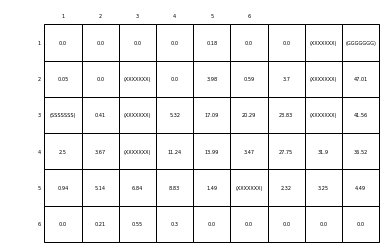

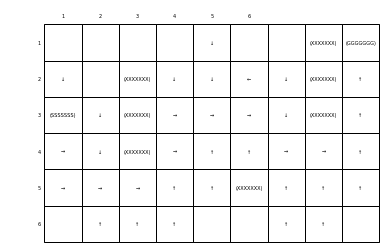



 Table Value Function in episode:  49 in planning step:  5  of run:  0

optimal_values: [[ 4.  4.  5.  7. 12. 13. 14.  0.  0.]
 [ 7.  7.  0. 11. 20. 20. 24.  0. 97.]
 [12. 10.  0. 22. 38. 45. 51.  0. 87.]
 [15. 18.  0. 35. 41. 34. 62. 70. 78.]
 [13. 22. 26. 30. 23.  0. 30. 34. 39.]
 [ 9. 12. 15. 17. 16. 13. 20. 24. 27.]]

q_policy: [[1 1 3 3 1 1 1 0 0]
 [1 1 0 3 1 1 1 0 0]
 [1 1 0 3 1 1 1 0 0]
 [3 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]]


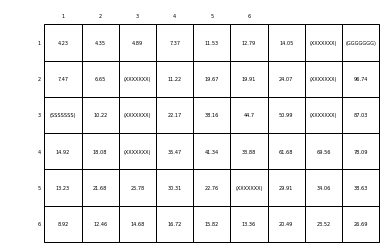

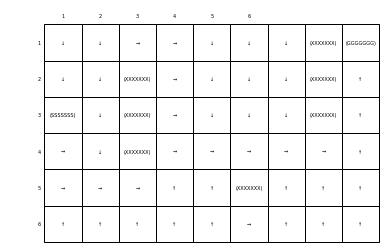



 Table Value Function in episode:  49 in planning step:  50  of run:  0

optimal_values: [[ 25.  27.  29.  33.  39.  42.  45.   0.   0.]
 [ 28.  28.   0.  39.  49.  52.  58.   0. 146.]
 [ 34.  33.   0.  52.  70.  79.  87.   0. 134.]
 [ 38.  43.   0.  67.  75.  70. 100. 111. 122.]
 [ 38.  48.  54.  60.  55.   0.  66.  73.  80.]
 [ 32.  37.  41.  45.  46.  45.  54.  60.  65.]]

q_policy: [[3 3 3 1 1 1 1 0 0]
 [1 0 0 1 1 1 1 0 0]
 [1 1 0 1 1 1 1 0 0]
 [1 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]]


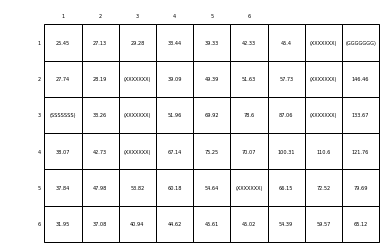

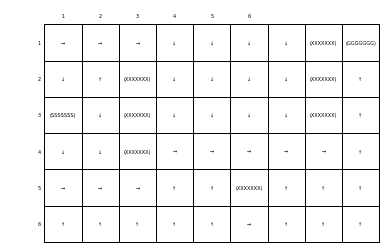

 10%|█         | 1/10 [00:18<02:46, 18.53s/it]



 Table Value Function in episode:  49 in planning step:  0  of run:  1

optimal_values: [[ 25.  27.  29.  33.  39.  42.  45.   0.   0.]
 [ 28.  28.   0.  39.  49.  52.  58.   0. 193.]
 [ 38.  34.   0.  52.  70.  81.  99.   0. 175.]
 [ 43.  49.   0.  67.  95.  93. 128. 143. 158.]
 [ 39.  57.  65.  74.  71.   0.  71.  75.  91.]
 [ 32.  37.  42.  45.  49.  45.  54.  60.  65.]]

q_policy: [[0 0 0 3 3 3 1 0 0]
 [1 1 0 1 0 0 1 0 0]
 [1 2 0 3 3 3 1 0 0]
 [3 1 0 0 3 3 3 3 0]
 [3 3 3 3 0 0 0 3 0]
 [0 0 0 3 0 0 0 0 0]]


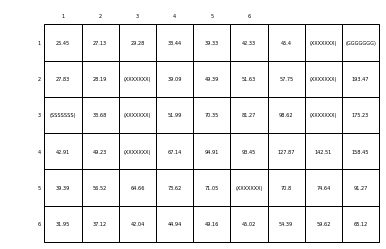

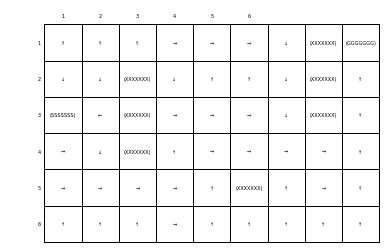



 Table Value Function in episode:  49 in planning step:  5  of run:  1

optimal_values: [[ 30.  32.  35.  43.  53.  42.  45.   0.   0.]
 [ 35.  36.   0.  52.  67.  74.  82.   0. 242.]
 [ 48.  46.   0.  71.  91. 105. 125.   0. 220.]
 [ 52.  63.   0.  91. 121. 123. 161. 179. 199.]
 [ 51.  73.  83.  94.  91.   0.  97. 104. 123.]
 [ 41.  49.  56.  60.  64.  58.  74.  83.  90.]]

q_policy: [[1 1 3 3 1 0 0 0 0]
 [1 1 0 1 1 3 1 0 0]
 [3 1 0 1 1 1 1 0 0]
 [3 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [3 0 0 0 0 3 0 0 0]]


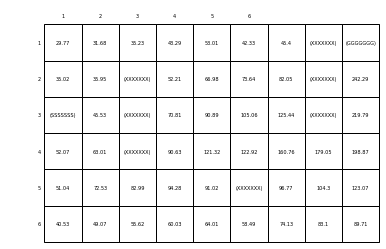

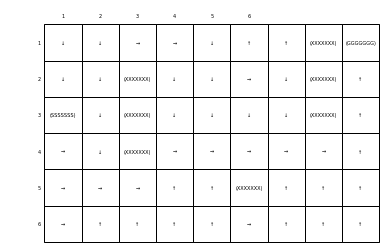



 Table Value Function in episode:  49 in planning step:  50  of run:  1

optimal_values: [[ 51.  54.  59.  69.  81.  72.  77.   0.   0.]
 [ 55.  57.   0.  80.  96. 105. 115.   0. 292.]
 [ 69.  68.   0. 100. 122. 139. 161.   0. 267.]
 [ 75.  87.   0. 122. 155. 159. 199. 220. 243.]
 [ 75.  98. 110. 124. 122.   0. 132. 144. 165.]
 [ 64.  74.  82.  88.  94.  91. 109. 120. 129.]]

q_policy: [[3 3 3 1 1 1 1 0 0]
 [1 0 0 1 1 1 1 0 0]
 [1 1 0 1 1 1 1 0 0]
 [1 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]]


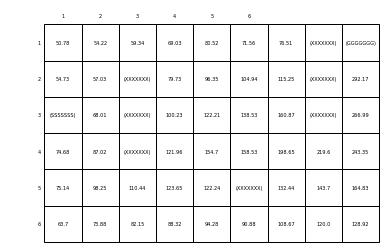

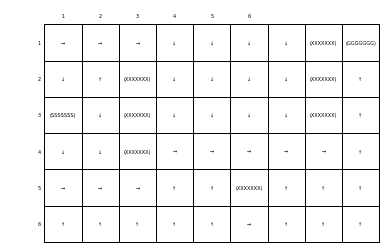

 20%|██        | 2/10 [00:38<02:36, 19.51s/it]



 Table Value Function in episode:  49 in planning step:  0  of run:  2

optimal_values: [[ 51.  54.  59.  69.  81.  72.  77.   0.   0.]
 [ 55.  57.   0.  80.  96. 105. 115.   0. 339.]
 [ 73.  68.   0. 101. 127. 145. 161.   0. 308.]
 [ 80.  89.   0. 139. 175. 182. 226. 251. 280.]
 [ 82. 107. 122. 138. 127.   0. 141. 145. 167.]
 [ 64.  74.  83.  90.  94.  91. 109. 120. 129.]]

q_policy: [[0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 2 0 0]
 [1 1 0 3 1 1 2 0 0]
 [1 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0]]


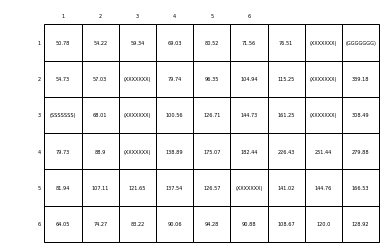

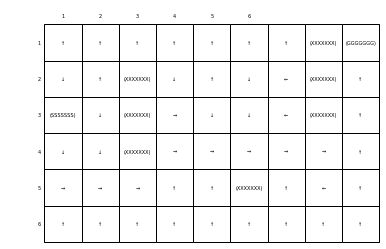



 Table Value Function in episode:  49 in planning step:  5  of run:  2

optimal_values: [[ 55.  57.  64.  76.  90.  84.  92.   0.   0.]
 [ 62.  63.   0.  91. 113. 122. 136.   0. 388.]
 [ 83.  78.   0. 116. 147. 169. 188.   0. 354.]
 [ 92. 103.   0. 160. 202. 212. 260. 288. 321.]
 [ 94. 123. 140. 159. 150.   0. 168. 174. 199.]
 [ 72.  86.  98. 106. 110. 107. 130. 141. 154.]]

q_policy: [[1 1 3 3 1 1 1 0 0]
 [1 1 0 3 1 1 1 0 0]
 [1 1 0 1 1 1 1 0 0]
 [3 1 0 3 3 3 3 3 0]
 [3 3 3 3 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]]


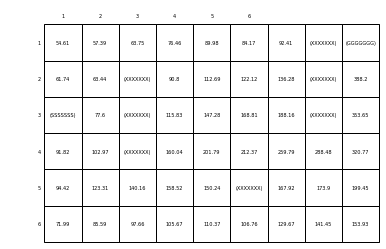

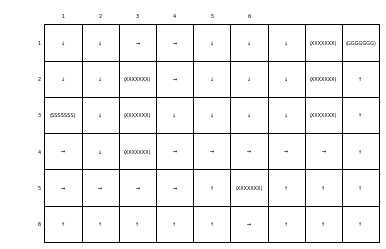



 Table Value Function in episode:  49 in planning step:  50  of run:  2

optimal_values: [[ 74.  76.  64. 104. 119. 115. 121.   0.   0.]
 [ 83.  83.   0. 120. 143. 155. 167.   0. 438.]
 [105.  99.   0. 146. 180. 204. 225.   0. 401.]
 [116. 125.   0. 193. 237. 249. 299. 330. 365.]
 [120. 150. 169. 189. 183.   0. 205. 205. 228.]
 [ 96. 111. 112. 135. 141. 139. 164. 174. 154.]]

q_policy: [[1 1 0 1 3 1 2 0 0]
 [1 1 0 1 1 1 2 0 0]
 [1 1 0 1 1 1 1 0 0]
 [1 2 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 1 2]
 [3 0 3 0 0 3 0 2 0]]


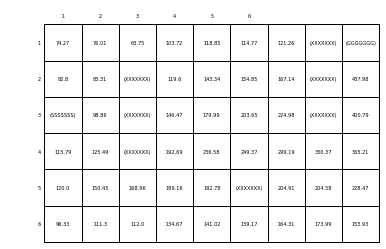

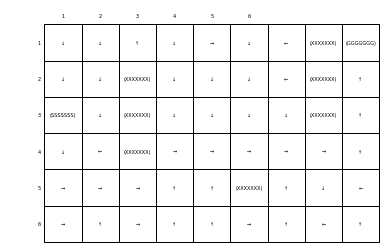

 30%|███       | 3/10 [00:57<02:14, 19.16s/it]



 Table Value Function in episode:  49 in planning step:  0  of run:  3

optimal_values: [[ 74.  76.  64. 104. 119. 115. 121.   0.   0.]
 [ 83.  83.   0. 120. 143. 155. 167.   0. 485.]
 [107.  99.   0. 146. 180. 204. 225.   0. 442.]
 [118. 129.   0. 193. 237. 249. 300. 334. 402.]
 [121. 155. 170. 192. 184.   0. 206. 215. 260.]
 [ 96. 118. 120. 145. 154. 155. 184. 197. 181.]]

q_policy: [[0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0]
 [1 2 0 0 0 0 1 0 0]
 [3 1 0 1 0 3 3 3 0]
 [3 1 1 1 1 0 3 3 0]
 [3 3 3 3 3 3 3 3 0]]


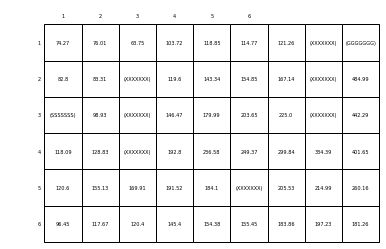

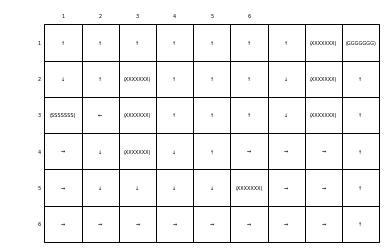



 Table Value Function in episode:  49 in planning step:  5  of run:  3

optimal_values: [[ 80.  81.  68. 111. 129. 128. 121.   0.   0.]
 [ 90.  91.   0. 128. 156. 171. 185.   0. 535.]
 [117. 110.   0. 153. 190. 213. 246.   0. 489.]
 [130. 142.   0. 200. 246. 249. 324. 356. 445.]
 [133. 171. 188. 211. 206.   0. 233. 252. 300.]
 [106. 130. 135. 165. 179. 183. 214. 231. 218.]]

q_policy: [[1 1 3 3 3 1 0 0 0]
 [1 1 0 3 3 3 1 0 0]
 [1 1 0 3 0 2 1 0 0]
 [3 1 0 3 0 0 1 2 0]
 [3 3 3 3 1 0 1 3 0]
 [3 3 3 3 3 3 3 0 0]]


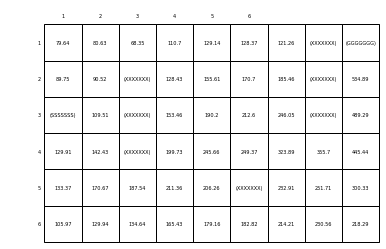

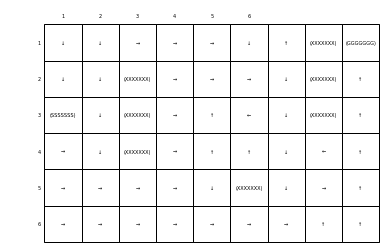



 Table Value Function in episode:  49 in planning step:  50  of run:  3

optimal_values: [[101. 103.  93. 137. 157. 158. 153.   0.   0.]
 [110. 112.   0. 156. 186. 203. 219.   0. 585.]
 [139. 132.   0. 183. 222. 247. 282.   0. 536.]
 [153. 167.   0. 232. 280. 286. 363. 397. 489.]
 [158. 197. 216. 241. 238.   0. 269. 290. 341.]
 [129. 155. 161. 194. 209. 215. 248. 267. 257.]]

q_policy: [[3 3 3 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0]
 [1 1 0 1 1 1 1 0 0]
 [1 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]]


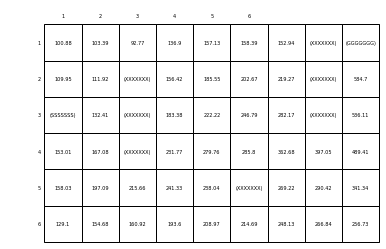

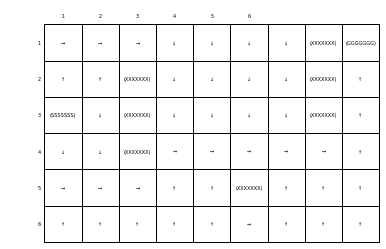

 40%|████      | 4/10 [01:15<01:53, 18.87s/it]



 Table Value Function in episode:  49 in planning step:  0  of run:  4

optimal_values: [[101. 103.  93. 137. 157. 158. 153.   0.   0.]
 [110. 112.   0. 156. 186. 203. 219.   0. 632.]
 [142. 137.   0. 183. 222. 250. 285.   0. 578.]
 [154. 174.   0. 235. 300. 309. 390. 429. 526.]
 [159. 206. 226. 255. 255.   0. 271. 290. 349.]
 [129. 155. 161. 198. 213. 215. 248. 267. 257.]]

q_policy: [[0 0 0 0 0 0 0 0 0]
 [1 2 0 3 3 1 0 0 0]
 [3 1 0 0 0 1 1 0 0]
 [3 1 0 3 3 3 3 3 0]
 [3 3 3 3 0 0 0 1 0]
 [0 3 3 0 0 0 0 3 0]]


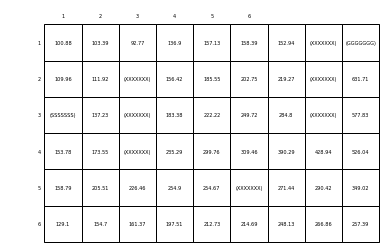

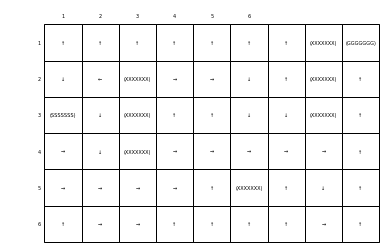



 Table Value Function in episode:  49 in planning step:  5  of run:  4

optimal_values: [[112. 118. 110. 156. 177. 174. 168.   0.   0.]
 [120. 125.   0. 178. 210. 224. 238.   0. 681.]
 [152. 149.   0. 205. 249. 276. 309.   0. 624.]
 [161. 182.   0. 259. 330. 342. 427. 469. 569.]
 [165. 215. 241. 274. 279.   0. 303. 317. 385.]
 [134. 162. 172. 212. 232. 239. 277. 297. 290.]]

q_policy: [[3 3 3 1 1 1 1 0 0]
 [3 0 0 3 1 1 1 0 0]
 [3 0 0 3 1 1 1 0 0]
 [0 0 0 3 3 3 3 3 0]
 [3 3 3 3 0 0 0 1 0]
 [3 3 3 0 3 3 0 3 0]]


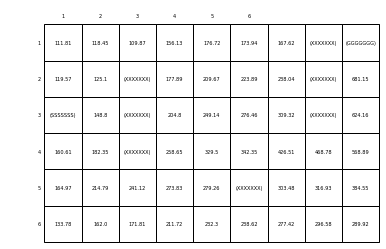

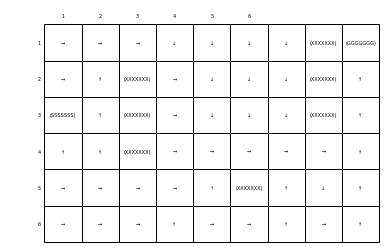



 Table Value Function in episode:  49 in planning step:  50  of run:  4

optimal_values: [[133. 141. 134. 182. 204. 203. 199.   0.   0.]
 [139. 146.   0. 205. 239. 255. 271.   0. 731.]
 [173. 171.   0. 234. 281. 310. 345.   0. 671.]
 [183. 207.   0. 290. 363. 378. 465. 510. 612.]
 [189. 241. 269. 303. 311.   0. 339. 355. 425.]
 [156. 186. 198. 239. 262. 270. 311. 332. 328.]]

q_policy: [[3 3 3 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0]
 [1 1 0 1 1 1 1 0 0]
 [1 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]]


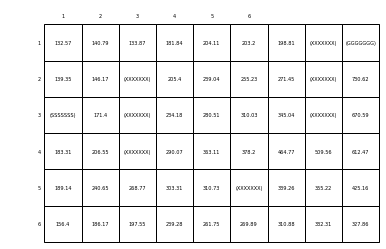

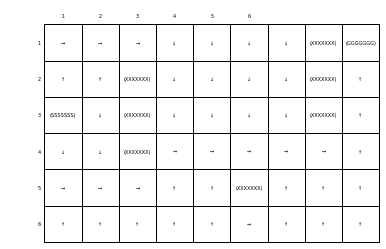

 50%|█████     | 5/10 [01:45<01:53, 22.63s/it]



 Table Value Function in episode:  49 in planning step:  0  of run:  5

optimal_values: [[133. 141. 134. 182. 204. 203. 199.   0.   0.]
 [139. 146.   0. 205. 239. 255. 271.   0. 778.]
 [177. 171.   0. 234. 281. 314. 347.   0. 712.]
 [188. 207.   0. 291. 383. 402. 492. 541. 649.]
 [196. 249. 280. 317. 327.   0. 341. 356. 432.]
 [157. 188. 198. 240. 266. 270. 311. 332. 328.]]

q_policy: [[0 0 0 0 1 0 0 0 0]
 [1 0 0 0 1 0 0 0 0]
 [1 2 0 3 3 1 1 0 0]
 [1 2 0 3 3 3 3 3 0]
 [3 3 3 3 0 0 0 3 0]
 [0 0 2 3 0 3 0 0 0]]


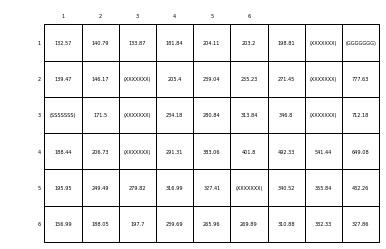

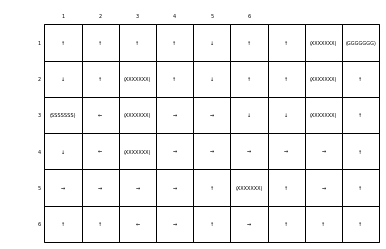



 Table Value Function in episode:  49 in planning step:  5  of run:  5

optimal_values: [[137. 144. 139. 190. 216. 216. 213.   0.   0.]
 [146. 152.   0. 217. 256. 275. 291.   0. 827.]
 [188. 182.   0. 252. 303. 338. 372.   0. 759.]
 [201. 221.   0. 316. 411. 433. 527. 580. 692.]
 [209. 266. 299. 339. 351.   0. 367. 387. 467.]
 [166. 200. 213. 255. 283. 286. 332. 356. 357.]]

q_policy: [[1 1 3 3 1 1 1 0 0]
 [1 1 0 3 1 1 1 0 0]
 [1 1 0 1 1 1 1 0 0]
 [3 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]]


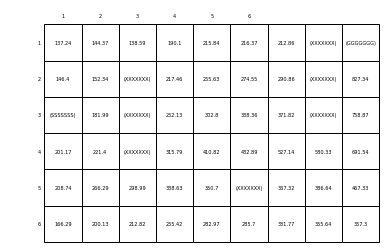

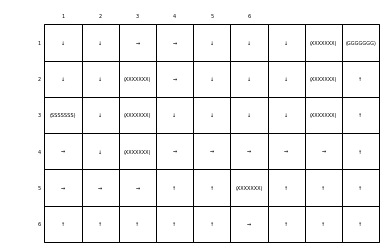



 Table Value Function in episode:  49 in planning step:  50  of run:  5

optimal_values: [[159. 168. 164. 217. 245. 247. 245.   0.   0.]
 [167. 175.   0. 246. 286. 307. 325.   0. 877.]
 [208. 203.   0. 283. 335. 373. 409.   0. 806.]
 [223. 241.   0. 348. 445. 470. 567. 622. 736.]
 [231. 288. 325. 369. 383.   0. 404. 416. 499.]
 [190. 226. 240. 285. 314. 319. 367. 384. 357.]]

q_policy: [[3 3 3 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0]
 [1 0 0 3 3 3 3 3 0]
 [1 2 1 0 0 0 0 3 0]
 [3 3 3 0 0 3 0 2 0]]


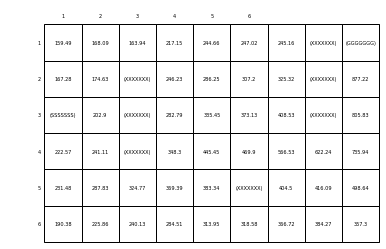

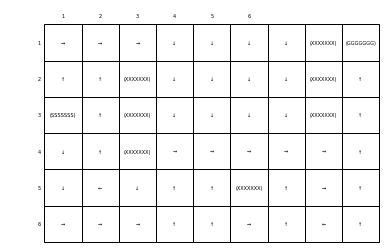

 60%|██████    | 6/10 [02:04<01:25, 21.42s/it]



 Table Value Function in episode:  49 in planning step:  0  of run:  6

optimal_values: [[159. 168. 164. 217. 245. 247. 245.   0.   0.]
 [168. 175.   0. 246. 286. 307. 325.   0. 924.]
 [212. 208.   0. 284. 336. 375. 418.   0. 847.]
 [223. 248.   0. 365. 466. 494. 594. 654. 772.]
 [232. 297. 336. 383. 386.   0. 408. 424. 500.]
 [191. 228. 240. 286. 314. 319. 367. 384. 357.]]

q_policy: [[0 0 0 0 0 1 0 0 0]
 [1 2 0 0 3 1 2 0 0]
 [3 1 0 1 3 3 1 0 0]
 [3 1 0 3 3 3 3 3 0]
 [1 3 3 0 2 0 0 0 2]
 [3 0 2 0 0 0 3 3 0]]


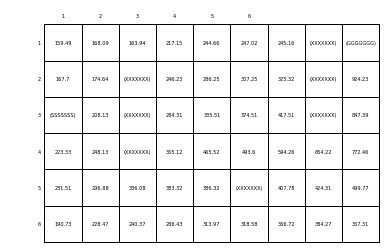

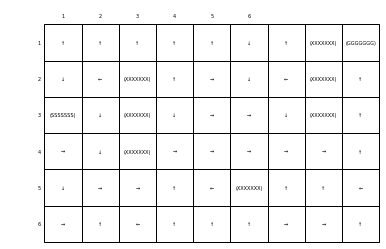



 Table Value Function in episode:  49 in planning step:  5  of run:  6

optimal_values: [[170. 183. 181. 236. 262. 268. 262.   0.   0.]
 [179. 187.   0. 267. 310. 334. 347.   0. 974.]
 [221. 218.   0. 301. 358. 404. 446.   0. 895.]
 [231. 255.   0. 385. 492. 526. 631. 694. 816.]
 [237. 304. 347. 399. 407.   0. 440. 461. 525.]
 [195. 235. 249. 299. 330. 340. 394. 416. 384.]]

q_policy: [[3 3 3 1 1 1 1 0 0]
 [3 0 0 3 3 1 1 0 0]
 [0 0 0 1 3 1 1 0 0]
 [0 0 0 3 3 3 3 3 0]
 [0 3 3 0 0 0 0 0 0]
 [3 3 3 0 3 3 3 0 2]]


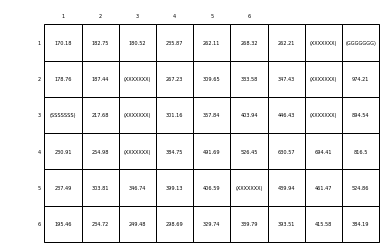

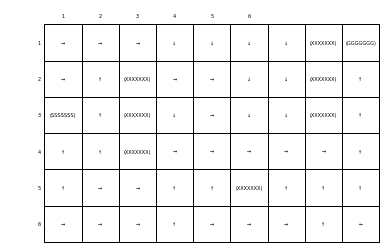



 Table Value Function in episode:  49 in planning step:  50  of run:  6

optimal_values: [[ 193.  207.  206.  263.  291.  299.  295.    0.    0.]
 [ 200.  210.    0.  296.  341.  366.  382.    0. 1024.]
 [ 244.  242.    0.  332.  391.  439.  484.    0.  942.]
 [ 255.  281.    0.  418.  527.  564.  670.  737.  861.]
 [ 263.  331.  376.  430.  440.    0.  477.  501.  558.]
 [ 219.  260.  277.  328.  361.  372.  428.  452.  417.]]

q_policy: [[3 3 3 1 1 1 1 0 0]
 [0 0 0 1 1 3 1 0 0]
 [1 1 0 1 1 1 1 0 0]
 [1 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 0 2]
 [0 0 0 0 0 3 0 0 0]]


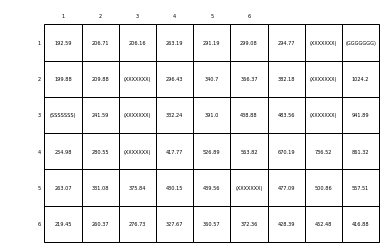

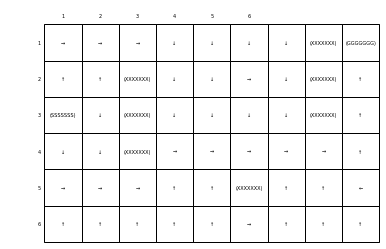

 70%|███████   | 7/10 [02:20<00:58, 19.60s/it]



 Table Value Function in episode:  49 in planning step:  0  of run:  7

optimal_values: [[ 193.  207.  206.  263.  291.  299.  295.    0.    0.]
 [ 200.  210.    0.  296.  341.  366.  388.    0. 1071.]
 [ 246.  244.    0.  333.  394.  459.  507.    0.  984.]
 [ 255.  284.    0.  429.  541.  581.  698.  769.  898.]
 [ 264.  336.  383.  439.  441.    0.  479.  505.  560.]
 [ 219.  260.  278.  328.  361.  372.  428.  452.  417.]]

q_policy: [[0 0 0 0 0 3 1 0 0]
 [1 1 0 0 3 1 1 0 0]
 [3 1 0 3 1 3 1 0 0]
 [3 1 0 3 3 0 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [0 3 0 2 0 0 0 0 0]]


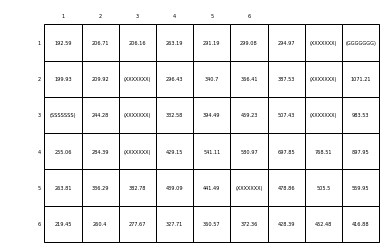

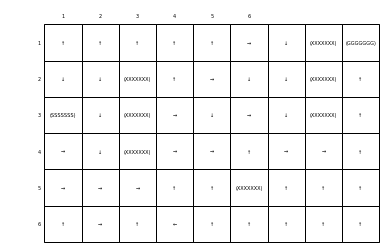



 Table Value Function in episode:  49 in planning step:  5  of run:  7

optimal_values: [[ 196.  209.  208.  266.  296.  306.  306.    0.    0.]
 [ 205.  213.    0.  302.  347.  377.  402.    0. 1121.]
 [ 254.  250.    0.  339.  404.  473.  527.    0. 1029.]
 [ 264.  294.    0.  443.  555.  599.  721.  804.  939.]
 [ 275.  349.  397.  456.  459.    0.  506.  539.  597.]
 [ 227.  269.  290.  347.  382.  397.  456.  483.  446.]]

q_policy: [[1 1 3 1 3 3 1 0 0]
 [1 2 0 3 1 1 1 0 0]
 [1 1 0 3 1 3 1 0 0]
 [1 1 0 1 3 3 1 3 0]
 [3 3 3 1 1 0 3 3 0]
 [0 3 0 3 3 3 3 0 0]]


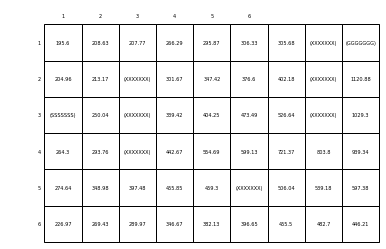

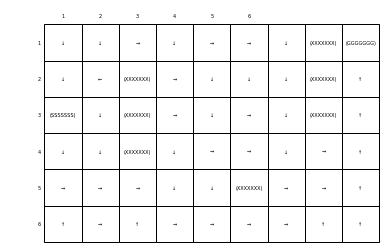



 Table Value Function in episode:  49 in planning step:  50  of run:  7

optimal_values: [[ 217.  232.  233.  293.  324.  336.  338.    0.    0.]
 [ 225.  235.    0.  330.  378.  409.  436.    0. 1171.]
 [ 275.  273.    0.  370.  437.  508.  563.    0. 1077.]
 [ 288.  319.    0.  475.  589.  636.  761.  846.  984.]
 [ 299.  376.  426.  486.  491.    0.  543.  578.  639.]
 [ 250.  294.  317.  375.  413.  429.  490.  519.  485.]]

q_policy: [[3 3 3 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0]
 [1 1 0 1 1 1 1 0 0]
 [1 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 3 0]
 [0 0 0 0 0 3 0 0 0]]


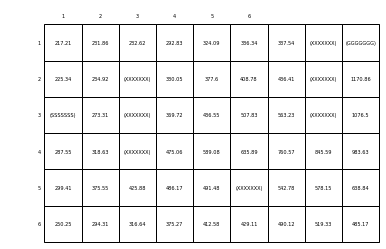

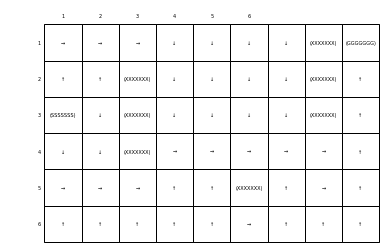

 80%|████████  | 8/10 [02:36<00:36, 18.50s/it]



 Table Value Function in episode:  49 in planning step:  0  of run:  8

optimal_values: [[ 217.  232.  233.  293.  324.  336.  338.    0.    0.]
 [ 226.  235.    0.  330.  378.  409.  436.    0. 1218.]
 [ 279.  274.    0.  370.  437.  514.  569.    0. 1118.]
 [ 293.  326.    0.  477.  609.  660.  788.  878. 1020.]
 [ 300.  385.  437.  500.  508.    0.  543.  587.  641.]
 [ 250.  294.  318.  375.  415.  429.  490.  519.  485.]]

q_policy: [[0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 0 0]
 [1 1 0 0 3 1 1 0 0]
 [3 1 0 1 3 3 3 3 0]
 [3 3 3 3 0 0 3 0 0]
 [3 0 0 2 0 3 0 0 0]]


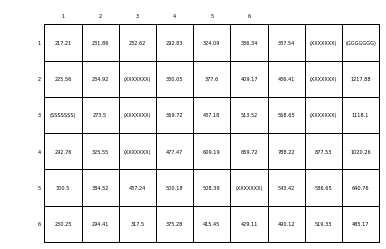

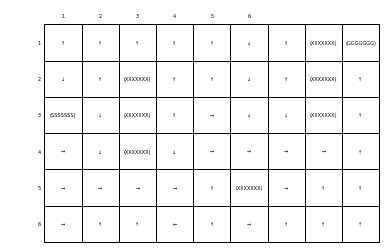



 Table Value Function in episode:  49 in planning step:  5  of run:  8

optimal_values: [[ 221.  236.  238.  302.  335.  350.  338.    0.    0.]
 [ 232.  241.    0.  343.  393.  426.  452.    0. 1267.]
 [ 289.  283.    0.  386.  457.  534.  586.    0. 1164.]
 [ 304.  338.    0.  499.  634.  687.  819.  917. 1063.]
 [ 311.  399.  454.  519.  528.    0.  576.  622.  677.]
 [ 258.  305.  330.  390.  431.  449.  517.  550.  515.]]

q_policy: [[1 1 3 1 3 1 0 0 0]
 [1 1 0 1 3 1 1 0 0]
 [1 1 0 1 1 1 2 0 0]
 [3 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 3 0 0]
 [3 0 0 0 3 3 0 0 0]]


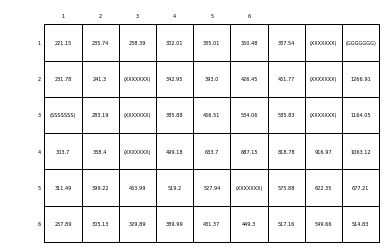

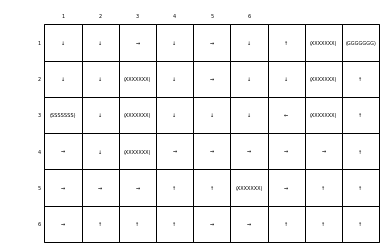



 Table Value Function in episode:  49 in planning step:  50  of run:  8

optimal_values: [[ 243.  259.  263.  328.  363.  380.  369.    0.    0.]
 [ 252.  263.    0.  371.  423.  458.  486.    0. 1317.]
 [ 310.  307.    0.  416.  488.  568.  622.    0. 1211.]
 [ 327.  363.    0.  531.  668.  723.  858.  958. 1107.]
 [ 336.  426.  482.  549.  556.    0.  612.  661.  719.]
 [ 281.  330.  356.  418.  461.  481.  551.  586.  554.]]

q_policy: [[3 3 3 1 1 3 1 0 0]
 [0 0 0 1 1 1 1 0 0]
 [1 1 0 1 1 1 1 0 0]
 [1 1 0 3 3 3 3 3 0]
 [3 3 3 0 2 0 0 0 0]
 [0 0 3 0 3 3 0 0 0]]


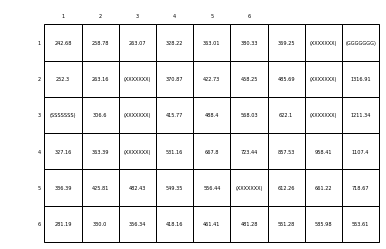

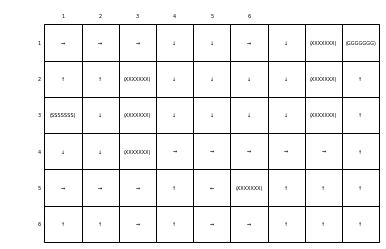

 90%|█████████ | 9/10 [02:52<00:17, 17.65s/it]



 Table Value Function in episode:  49 in planning step:  0  of run:  9

optimal_values: [[ 243.  264.  270.  337.  364.  380.  369.    0.    0.]
 [ 255.  267.    0.  382.  437.  461.  486.    0. 1364.]
 [ 312.  307.    0.  419.  505.  588.  646.    0. 1253.]
 [ 327.  363.    0.  531.  669.  732.  885.  990. 1144.]
 [ 336.  426.  482.  549.  556.    0.  615.  663.  723.]
 [ 281.  330.  356.  418.  461.  481.  551.  586.  554.]]

q_policy: [[1 3 3 1 2 0 1 0 0]
 [3 0 0 3 1 2 2 0 0]
 [0 0 0 3 3 3 1 0 0]
 [0 0 0 0 3 3 3 3 0]
 [0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


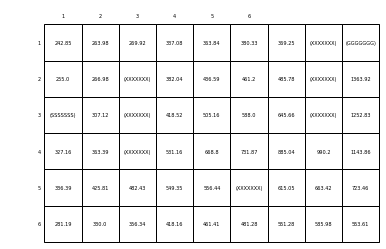

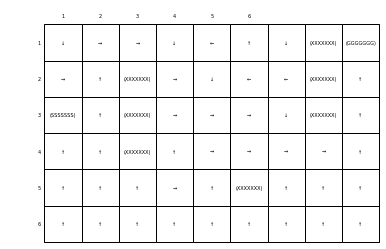



 Table Value Function in episode:  49 in planning step:  5  of run:  9

optimal_values: [[ 252.  276.  284.  353.  376.  392.  384.    0.    0.]
 [ 264.  278.    0.  400.  451.  477.  506.    0. 1413.]
 [ 320.  314.    0.  439.  525.  611.  672.    0. 1297.]
 [ 332.  370.    0.  555.  695.  762.  918. 1027. 1184.]
 [ 344.  437.  497.  568.  578.    0.  643.  693.  757.]
 [ 287.  337.  368.  433.  476.  496.  573.  609.  579.]]

q_policy: [[3 3 3 1 2 1 1 0 0]
 [3 0 0 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0]
 [0 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]]


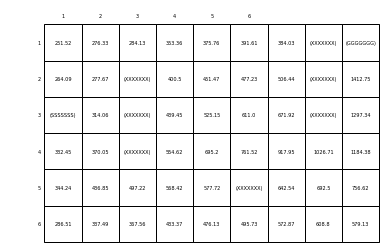

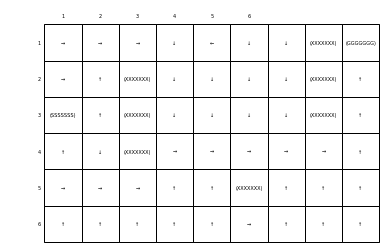



 Table Value Function in episode:  49 in planning step:  50  of run:  9

optimal_values: [[ 271.  300.  309.  380.  401.  392.  384.    0.    0.]
 [ 285.  300.    0.  429.  476.  477.  506.    0. 1463.]
 [ 342.  337.    0.  470.  554.  646.  694.    0. 1344.]
 [ 356.  395.    0.  587.  730.  798.  957. 1068. 1229.]
 [ 369.  463.  525.  599.  610.    0.  679.  731.  798.]
 [ 310.  363.  395.  462.  507.  528.  607.  645.  618.]]

q_policy: [[1 3 3 1 2 0 0 0 0]
 [1 0 0 1 0 0 0 0 0]
 [1 1 0 1 2 1 2 0 0]
 [1 1 0 3 3 3 3 3 0]
 [3 3 3 0 0 0 3 0 0]
 [0 3 0 0 0 3 0 0 0]]


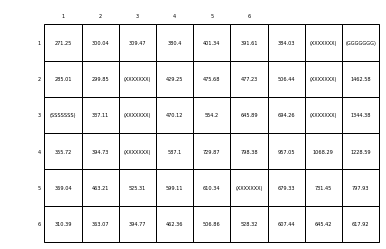

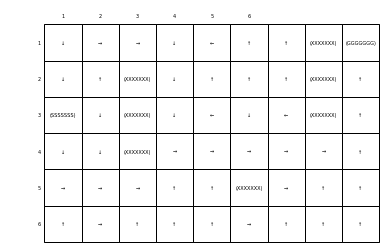

100%|██████████| 10/10 [03:07<00:00, 18.78s/it]


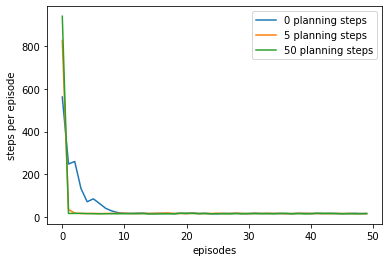

In [24]:
if __name__ == '__main__':


    # set up an instance for DynaMaze
    dyna_maze = Maze()
    dyna_params = DynaParams()

    runs = 10 # 10 originally
    episodes = 50 # 50 originally
    planning_steps = [0, 5, 50]
    #planning_steps = [0, 5]
    #planning_steps = [0]
    steps = np.zeros((len(planning_steps), episodes))
    steps_2 = np.zeros((len(planning_steps), episodes))
    q_values = np.zeros((dyna_maze.WORLD_HEIGHT, dyna_maze.WORLD_WIDTH))
    q_policies = np.zeros((dyna_maze.WORLD_HEIGHT, dyna_maze.WORLD_WIDTH))


    #EMPEZAMOS LOS RUNS
    for run in tqdm(range(runs)):

        #PLANIFICACION DE N-STEPS = [0,5,50] ORIGINALMENTE
        for i, planning_step in enumerate(planning_steps):
            dyna_params.planning_steps = planning_step
            q_value = np.zeros(dyna_maze.q_size)

            # generate an instance of Dyna-Q model
            model = Model()

            #GENERAMOS LOS EPISODIOS PARA CADA N-STEP
            for ep in range(episodes):
                #print('\nrun:', run, 'planning step:', planning_step, 'episode:', ep, "dyna_params.planning_steps:", dyna_params.planning_steps)
                #steps_2[i, ep], q_values[i, ep] = dyna_q(q_value, model, dyna_maze, dyna_params)
                steps[i, ep] += steps_dyna_q(q_value, model, dyna_maze, dyna_params)
                q_values += value_dyna_q(q_value, model, dyna_maze, dyna_params) 
                q_policies = policy_dyna_q(q_value, model, dyna_maze, dyna_params) 
                #print("steps[", i,",", ep,"]", steps[i, ep])

            ## imprimimos el q_value para cada planning steps
            print("\n\n Table Value Function in episode: ",ep, "in planning step: ", planning_step, " of run: ", run)
            draw_values(np.round(q_values, decimals=2), dyna_maze)
            #plt.savefig('./images/tabular-Dyna-Q_VALUES_'+ str(run) + '_' + str(ep) +'.png')
            #print("\n-------------------")

            ## imprimimos la policy para cada planning steps
            #print("\n\n Table Policy in episode: ",ep, "in planning step: ", planning_step, " of run: ", run)
            draw_policy(q_values, q_policies, dyna_maze)
            #plt.savefig('./images/figure_3_5.png')
            #plt.savefig('./images/tabular-Dyna-POLICY_'+ str(run) + '_' + str(ep) +'.png')


            #print("q_values:", q_values)
          #print("steps --->:", steps)


    #print("\n steps --->:", steps)
    # Dibujamos la matriz con los valores para cada celda



    # Dibujamos la matriz con la politica para cada estado



    # averaging over runs
    steps /= runs
    #print("steps avereged: ", steps)

    for i in range(len(planning_steps)):
        plt.plot(steps[i, :], label='%d planning steps' % (planning_steps[i]))
    plt.xlabel('episodes')
    plt.ylabel('steps per episode')
    plt.legend()
    plt.show()
    #plt.savefig('../images/figure_8_2.png')
    plt.close()

# A partir de aquí es código de trabajo

In [25]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTIONS_FIGS=['↑', '↓', '←', '→']
print(ACTIONS_FIGS[0:2])

['↑', '↓']


In [26]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
np_array = np.array((1, 5, 9, 3, 7, 2, 0))
np.where(np_array == 9)
print(np.where(np_array == 9))
np.where(max(np_array) == np_array)

In [ ]:
data = np.ones((3,3,2))
#print(data)
data2 = np.array([[(1,2),(3,4)],[(5,6),(7,8)],[(9,10),(11,12)]])
print(data2)
print(data2.shape)
print(data2[0,1,0])
print(data2[0,1,1])
print(np.where(data2.max(axis=1)))
a = np.where(data2.max(axis=2))
listOfCordinates = list(zip(a[0], a[1]))
# travese over the list of cordinates
for cord in listOfCordinates:
    print(cord)

#print(data2[:,:,max])
#print(data2.max(axis=2))int()
print(data2[0,0])

In [ ]:
a = np.arange(18).reshape(2,3,3) + 10
print(a)
print(a[0,0,2])
print(a.shape)
print(np.argmax(a))
print(np.argmax(a, axis=0))
print(np.argmax(a, axis=1))
print(np.argmax(a, axis=2))
#a[2,2]
b = np.arange(216).reshape(6,9,4)
#print(b)
#print(b.shape)
ind = np.unravel_index(np.argmax(b, axis=None), b.shape)
#print(ind)


In [ ]:
c = np.array([[(1,2,0),(3,4,5), (7,8,9)],[(5,6,1),(7,8,0),(0,0,1)]])
print(c)
print(c[0,0,2])
print(c.shape)
#print(np.argmax(c, axis=0))
#print(np.argmax(c, axis=1))
print(np.argmax(c, axis=2)) # devuelve el indice de la 3 D que es lo que quiero. Ese valor lo convierto a las flechitas

In [ ]:
c[c == 0] = -1000
c

In [ ]:
d = np.ones((3,3))
print(d)
e = np.zeros((3,3))
#print(e)
e[2,0] = 0.5
print(e)
d[e == 0] = -1999
print(d) 

In [ ]:
result = np.where(data2 == np.max(data2, axis=2))

In [ ]:
g = [[0, 8]]
g[0]

In [ ]:
a = "uno"
b = 2
c = a + str(b)
print(c)

In [ ]:
obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
obstacles[6]
for i, _ in enumerate(obstacles):
    print("El valor de obstacles[{0}] es {1}".format(i,obstacles[i]))
